### TRABAJO PRACTICO FINAL

Alumnos: Fernando Vasconcelos, Victoria Teran y Lara Rosenberg

#### OBJETIVO DEL TRABAJO
Partiendo de imagenes de caras de personas, el objetivo será crear un modelo que identifique si son personas jovenes, de edad media o de edad más avanzada

In [1]:
# Importamos las librerias necesarias
import kagglehub
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import os
import torch
import torchvision
import torchsummary
import torchmetrics
from torch.utils.tensorboard import SummaryWriter
import shutil

2024-11-30 19:17:42.765798: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
# Descargamos el dataset
path = kagglehub.dataset_download("arashnic/faces-age-detection-dataset")

In [3]:
# Definimos las rutas
source_dir = path  # Esta es la ruta de descarga
destination_dir = '/content/faces-age-detection-dataset'  # El directorio donde queremos mover los datos

# Creamos el directorio de destino si no existe
os.makedirs(destination_dir, exist_ok=True)

# Movemos todos los archivos y carpetas del directorio de origen al destino
for item in os.listdir(source_dir):
    s = os.path.join(source_dir, item)
    d = os.path.join(destination_dir, item)
    shutil.move(s, d)

print("Los archivos han sido movidos a:", destination_dir)

PermissionError: [Errno 13] Permission denied: '/content'

In [6]:
# Leemos el csv que tiene el ID de las imagenes y la clase
df = pd.read_csv(path + '/faces/train.csv')

In [7]:
df.head()

,ID,Class
0,377.jpg,MIDDLE
1,17814.jpg,YOUNG
2,21283.jpg,MIDDLE
3,16496.jpg,YOUNG
4,4487.jpg,MIDDLE


In [8]:
df = pd.read_pickle('./df_cleaned.pkl')
df = df[df['face_detected'] == True]
df.reset_index(inplace=True)
df = df.drop(columns=['index', 'face_detected', 'height', 'width'])

In [9]:
df.head()

,ID,Class
0,377.jpg,MIDDLE
1,17814.jpg,YOUNG
2,21283.jpg,MIDDLE
3,16496.jpg,YOUNG
4,4487.jpg,MIDDLE


Evaluamos la distribucion de las clases

In [10]:
df.Class.value_counts()

Class
MIDDLE    7866
YOUNG     5655
OLD       1695
Name: count, dtype: int64

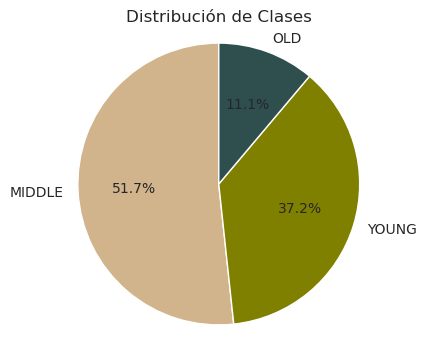

In [11]:
# Creamos el gráfico de torta
plt.figure(figsize=(4, 4))
plt.pie(df.Class.value_counts(), labels=df.Class.value_counts().index, autopct='%1.1f%%', startangle=90, colors=['tan', 'olive','darkslategrey'])
plt.axis('equal')

# Agregamos un título
plt.title('Distribución de Clases')

# Mostramos el gráfico
plt.show()

Como podemos ver, las clases se encuentran desbalanceadas.
Más de la mitad de las imagenes, son clasificadas como "middle".
Solo un 12% de las observaciones, corresponden a edades más avanzadas ("old")

Lo primero que vamos a hacer es revisar si todas las imagenes tienen el mismo tamaño

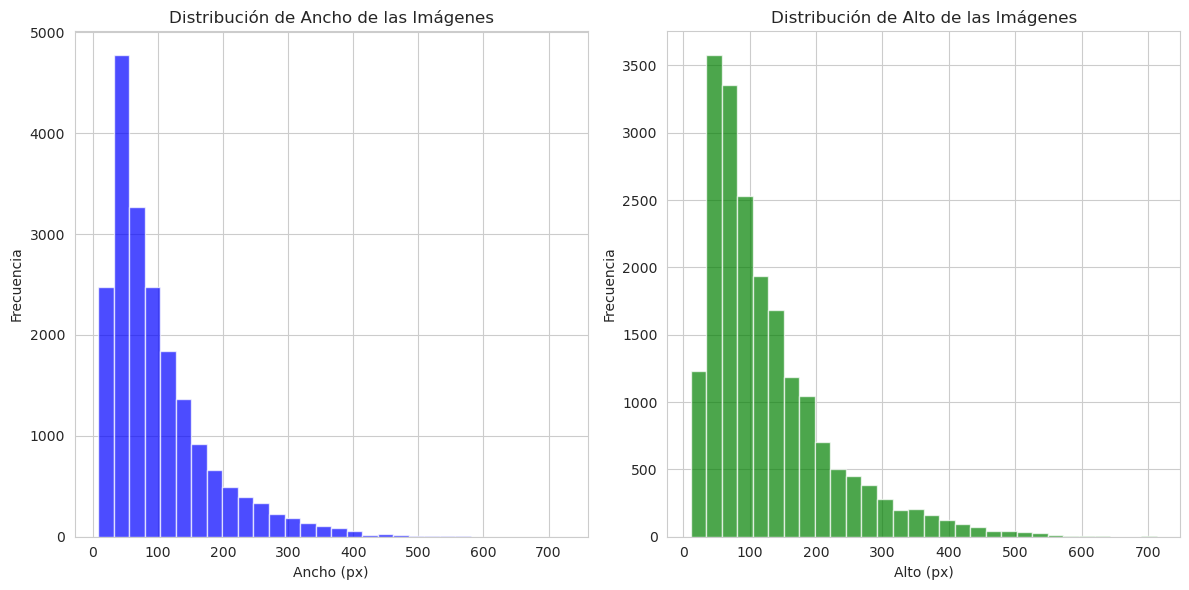

In [12]:
# Ruta a la carpeta donde están las imágenes
folder_path = path + '/faces/Train'

# Obtenemos todos los archivos de la carpeta
image_files = os.listdir(folder_path)

# Iniciamos listas para almacenar los valores de ancho y alto
widths = []
heights = []
image_sizes = []

# Iteramos sobre los archivos de la carpeta
for image_file in image_files:
    image_path = os.path.join(folder_path, image_file)
    with Image.open(image_path) as img:
        width, height = img.size
        image_sizes.append(img.size)
        widths.append(width)
        heights.append(height)

# Creamos los gráficos de distribución para ancho y alto
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Histograma del ancho de las imágenes
axes[0].hist(widths, bins=30, color='blue', alpha=0.7)
axes[0].set_title('Distribución de Ancho de las Imágenes')
axes[0].set_xlabel('Ancho (px)')
axes[0].set_ylabel('Frecuencia')

# Histograma del alto de las imágenes
axes[1].hist(heights, bins=30, color='green', alpha=0.7)
axes[1].set_title('Distribución de Alto de las Imágenes')
axes[1].set_xlabel('Alto (px)')
axes[1].set_ylabel('Frecuencia')

# Mostramos los gráficos
plt.tight_layout()
plt.show()

Como podemos ver, las imagenes presentan distintos tamaños, es decir, no son homogeneas.

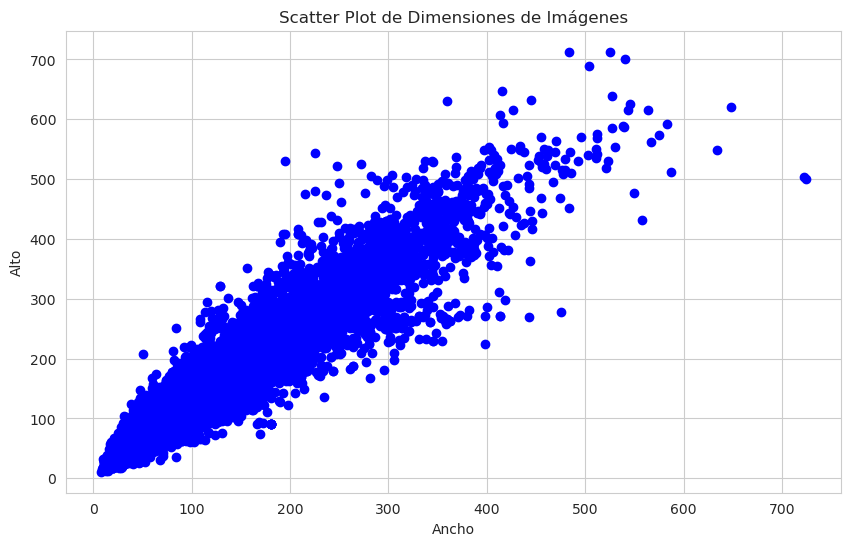

In [8]:
widths, heights = zip(*image_sizes)

# Creamos el scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(widths, heights, color='blue', marker='o')

# Configuramos el título y las etiquetas
plt.title('Scatter Plot de Dimensiones de Imágenes')
plt.xlabel('Ancho')
plt.ylabel('Alto')
plt.grid(True)

# Mostramos el plot
plt.show()

Como podemos ver, las imágenes no son cuadradas (suelen tener más largo que ancho).

Observamos las primeras 15 imagenes

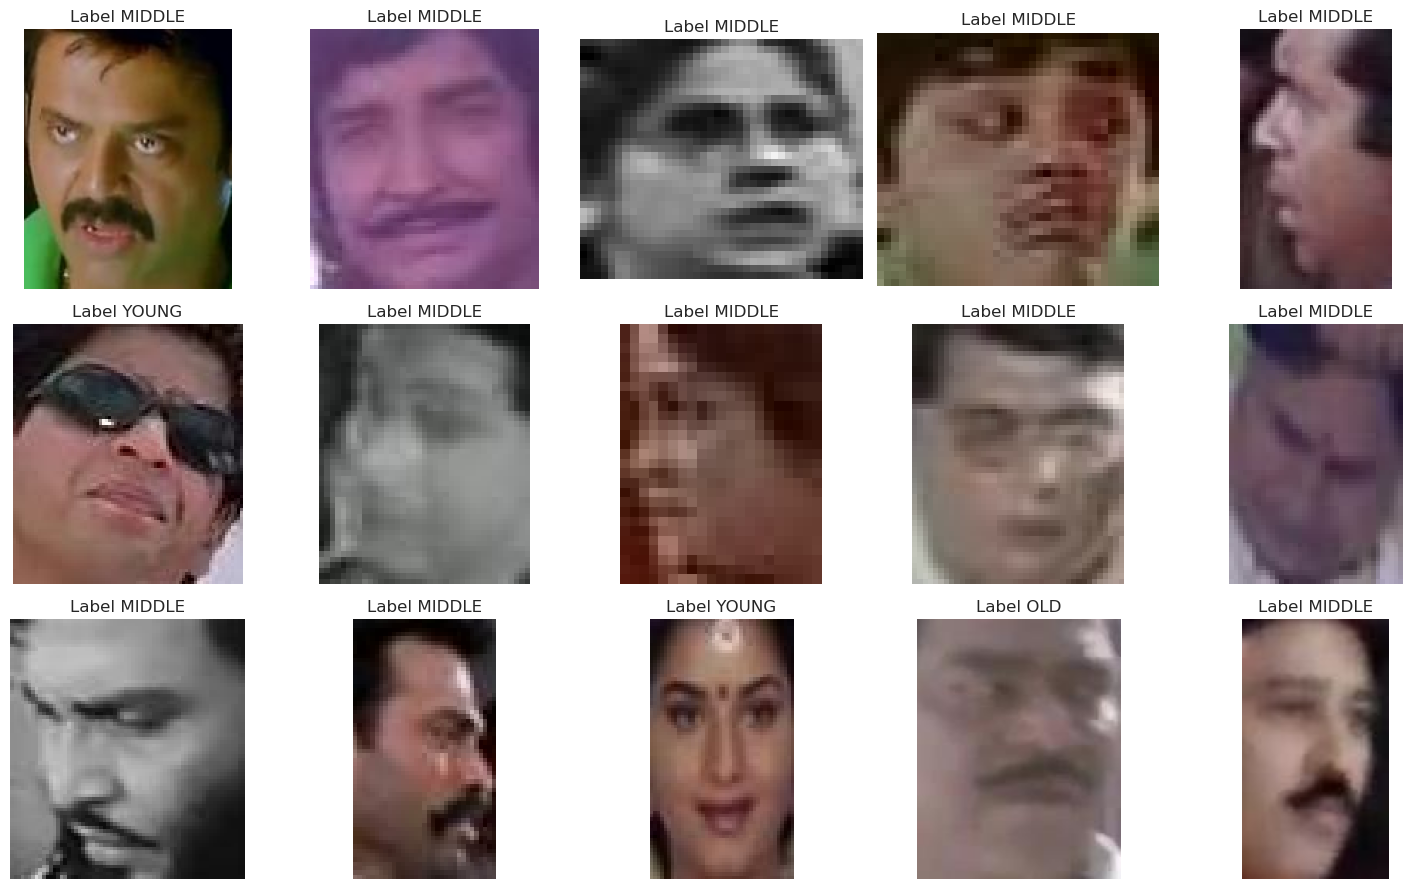

In [9]:
# Obtenemos todos los archivos de la carpeta
image_files = os.listdir(folder_path)
# Obtenemos las primeras 15 imágenes
first_15_images = image_files[:15]

fig, axes = plt.subplots(3, 5, figsize=(15, 9))

# Iteramos sobre las 15 primeras imágenes
for i, image_file in enumerate(first_15_images):
    image_path = os.path.join(folder_path, image_file)
    etiqueta = df[df['ID'] == image_file].iloc[0]['Class']

    with Image.open(image_path) as img:
        # Determinar la posición en la matriz
        row = i // 5
        col = i % 5

        # Mostramos la imagen en el gráfico
        axes[row, col].imshow(img)
        axes[row, col].axis('off')
        axes[row, col].set_title(f'Label {etiqueta}')

# Ajustamos el espacio entre las subgráficas
plt.tight_layout()

# Mostramos el gráfico
plt.show()

In [13]:
# Data Preprocessing --> cambiamos los labels de str a int
class_mapping = {'YOUNG': 0, 'MIDDLE': 1, 'OLD': 2}
df['Class'] = df['Class'].map(class_mapping)

In [14]:
# Dividimos los datos en conjuntos de entrenamiento y prueba
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['Class'])

print(f'Tamaño conjunto de entrenamiento: {len(train_df)}')
print(f'Tamaño conjunto de test: {len(test_df)}')

Tamaño conjunto de entrenamiento: 12172
Tamaño conjunto de test: 3044


In [15]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, images_dir, transform=None):
        self.dataframe = dataframe
        self.images_dir = images_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = self.dataframe.iloc[idx, 0]  # Nombre de la imagen (ID)
        label = self.dataframe.iloc[idx, 1]     # Clase correspondiente
        img_path = os.path.join(self.images_dir, img_name)

        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

Tamaño original de la imagen: 309x387


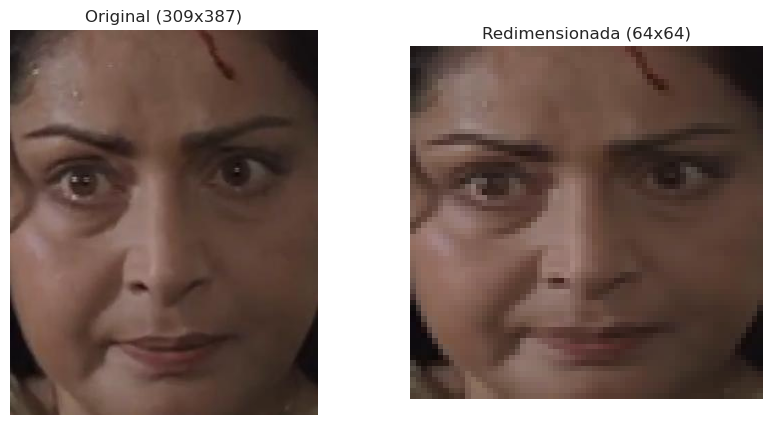

In [13]:
# Cargamos la imagen original
img_path = path + '/faces/Train/1.jpg'
original_image = Image.open(img_path)

# Mostramos las dimensiones de la imagen original
original_size = original_image.size
print(f"Tamaño original de la imagen: {original_size[0]}x{original_size[1]}")

# Definimos el tamaño del resize
resize_transform = transforms.Resize((64, 64), interpolation=Image.LANCZOS)

# Aplicamos la transformación sobre la imagen
resized_image = resize_transform(original_image)

# Mostramos las imágenes: original y redimensionada
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(original_image)
axes[0].set_title(f"Original ({original_size[0]}x{original_size[1]})")
axes[0].axis("off")

resized_size = resized_image.size
axes[1].imshow(resized_image)
axes[1].set_title(f"Redimensionada ({resized_size[0]}x{resized_size[1]})")
axes[1].axis("off")

plt.show()

1. ARQUITECTURA BASICA

In [16]:
CANTIDAD_CLASES = 3
ANCHO_IMAGENES = 112
ALTO_IMAGENES = 122

In [17]:
transform = transforms.Compose([
    transforms.Resize((ANCHO_IMAGENES, ALTO_IMAGENES), interpolation=Image.LANCZOS),
    transforms.ToTensor(),
])

In [18]:
images_dir = path + '/faces/Train'

# Creamos los datasets
train_dataset = CustomDataset(dataframe=train_df, images_dir=images_dir, transform=transform)
test_dataset = CustomDataset(dataframe=test_df, images_dir=images_dir, transform=transform)

# Creamos los dataloaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [105]:
class ConvModel(torch.nn.Module):
    def __init__(self, output_units):
        super().__init__()
        self.dropout2d = torch.nn.Dropout2d(0.3)
        self.conv1 = torch.nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding='same')
        self.bn1 = torch.nn.BatchNorm2d(16)
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding='same')
        self.bn2 = torch.nn.BatchNorm2d(32)
        self.pool2 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding='same')
        self.bn3 = torch.nn.BatchNorm2d(64)
        self.pool3 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv4 = torch.nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding='same')
        self.bn4 = torch.nn.BatchNorm2d(128)
        self.pool4 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = torch.nn.Linear(in_features=2048, out_features=512)
        self.dropout = torch.nn.Dropout(p=0.3)
        self.fc2 = torch.nn.Linear(in_features=512, out_features=output_units)

    def forward(self, x):
        x = self.pool1(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool2(torch.relu(self.bn2(self.conv2(x))))
        x = self.pool3(torch.relu(self.bn3(self.conv3(self.dropout2d(x)))))
        x = self.pool4(torch.relu(self.bn4(self.conv4(self.dropout2d(x)))))
        x = torch.flatten(x, 1)
        x = torch.relu(self.fc1(self.dropout(x)))
        x = self.fc2(x)
        return x

conv_model = ConvModel(CANTIDAD_CLASES)

# Si hay una GPU disponible muevo el modelo allí para aprovechar ese recurso
if torch.cuda.is_available():
    conv_model.to("cuda")

torchsummary.summary(conv_model, (3, ANCHO_IMAGENES, ALTO_IMAGENES))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 64, 64]             448
       BatchNorm2d-2           [-1, 16, 64, 64]              32
         MaxPool2d-3           [-1, 16, 32, 32]               0
            Conv2d-4           [-1, 32, 32, 32]           4,640
       BatchNorm2d-5           [-1, 32, 32, 32]              64
         MaxPool2d-6           [-1, 32, 16, 16]               0
         Dropout2d-7           [-1, 32, 16, 16]               0
            Conv2d-8           [-1, 64, 16, 16]          18,496
       BatchNorm2d-9           [-1, 64, 16, 16]             128
        MaxPool2d-10             [-1, 64, 8, 8]               0
        Dropout2d-11             [-1, 64, 8, 8]               0
           Conv2d-12            [-1, 128, 8, 8]          73,856
      BatchNorm2d-13            [-1, 128, 8, 8]             256
        MaxPool2d-14            [-1, 12

In [106]:
def train(model, optimizer, criterion, metric, data, epochs, tb_writer=None):

    train_loader = data["train"]
    valid_loader = data["valid"]

    train_writer = tb_writer["train"]
    valid_writer = tb_writer["valid"]

    if tb_writer:
        train_writer.add_graph(model, torch.zeros((1, 3, data["image_width"], data["image_height"])))
        valid_writer.add_graph(model, torch.zeros((1, 3, data["image_width"], data["image_height"])))

    if torch.cuda.is_available():
        model.to("cuda")
        metric.to("cuda")

    train_loss = []
    train_acc = []
    valid_loss = []
    valid_acc = []

    for epoch in range(epochs):

        # Pongo el modelo en modo entrenamiento
        model.train()

        epoch_train_loss = 0.0
        epoch_train_accuracy = 0.0

        for train_data, train_target in train_loader:

            if torch.cuda.is_available():
                train_data = train_data.to("cuda")
                train_target = train_target.to("cuda")

            optimizer.zero_grad()
            output = model(train_data.float())
            loss = criterion(output, train_target)
            epoch_train_loss += loss.item()
            loss.backward()
            optimizer.step()

            accuracy = metric(output, train_target)
            epoch_train_accuracy += accuracy.item()

        epoch_train_loss = epoch_train_loss / len(train_loader)
        epoch_train_accuracy = epoch_train_accuracy / len(train_loader)
        train_loss.append(epoch_train_loss)
        train_acc.append(epoch_train_accuracy)

        # Pongo el modelo en modo testeo
        model.eval()

        epoch_valid_loss = 0.0
        epoch_valid_accuracy = 0.0

        for valid_data, valid_target in valid_loader:
            if torch.cuda.is_available():
                valid_data = valid_data.to("cuda")
                valid_target = valid_target.to("cuda")

            output = model(valid_data.float())
            epoch_valid_loss += criterion(output, valid_target).item()
            epoch_valid_accuracy += metric(output, valid_target).item()

        epoch_valid_loss = epoch_valid_loss / len(valid_loader)
        epoch_valid_accuracy = epoch_valid_accuracy / len(valid_loader)
        valid_loss.append(epoch_valid_loss)
        valid_acc.append(epoch_valid_accuracy)

        print("Epoch: {}/{} - Train loss {:.6f} - Train Accuracy {:.6f} - Valid Loss {:.6f} - Valid Accuracy {:.6f}".format(
        epoch+1, epochs, epoch_train_loss, epoch_train_accuracy, epoch_valid_loss, epoch_valid_accuracy))

        if tb_writer:
            train_writer.add_scalar("loss", epoch_train_loss, epoch)
            valid_writer.add_scalar("loss", epoch_valid_loss, epoch)
            train_writer.add_scalar("accuracy", epoch_train_accuracy, epoch)
            valid_writer.add_scalar("accuracy", epoch_valid_accuracy, epoch)
            train_writer.flush()
            valid_writer.flush()

    history = {}
    history["train_loss"] = train_loss
    history["train_acc"] = train_acc
    history["valid_loss"] = valid_loss
    history["valid_acc"] = valid_acc

    return history




In [107]:
# Dado que las clases se encuentran desbalanceadas vamos a utilizar el argumento weight de CrossEntropy
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
class_counts = np.bincount(train_dataset.dataframe.Class)
class_weights = 1. / class_counts  # Invertir la frecuencia para dar más peso a las clases menos frecuentes
class_weights = class_weights / class_weights.sum()
weights = torch.tensor(class_weights, dtype=torch.float).to(device)

In [110]:
noaug_conv_model = ConvModel(CANTIDAD_CLASES)
noaug_optimizer = torch.optim.Adam(noaug_conv_model.parameters(), lr=0.001, weight_decay=0.001)
noaug_loss = torch.nn.CrossEntropyLoss(weight=weights)
noaug_metric = torchmetrics.Accuracy(task='multiclass', num_classes=CANTIDAD_CLASES,average='macro')
noaug_data = {"train": train_loader, "valid": test_loader, "image_width": ANCHO_IMAGENES, "image_height": ALTO_IMAGENES}

noaug_writer = {"train": SummaryWriter(log_dir="data_aug/noaug_train"),
                "valid": SummaryWriter(log_dir="data_aug/noaug_valid")}

history = train(noaug_conv_model,
                noaug_optimizer,
                noaug_loss,
                noaug_metric,
                noaug_data,
                15,
                noaug_writer)

Epoch: 1/15 - Train loss 0.999671 - Train Accuracy 0.512039 - Valid Loss 0.844359 - Valid Accuracy 0.629673
Epoch: 2/15 - Train loss 0.841627 - Train Accuracy 0.618756 - Valid Loss 0.857707 - Valid Accuracy 0.621778
Epoch: 3/15 - Train loss 0.796338 - Train Accuracy 0.654108 - Valid Loss 0.748180 - Valid Accuracy 0.678201
Epoch: 4/15 - Train loss 0.750306 - Train Accuracy 0.679263 - Valid Loss 0.707871 - Valid Accuracy 0.697889
Epoch: 5/15 - Train loss 0.719022 - Train Accuracy 0.690658 - Valid Loss 0.702998 - Valid Accuracy 0.706293
Epoch: 6/15 - Train loss 0.702766 - Train Accuracy 0.707656 - Valid Loss 0.664572 - Valid Accuracy 0.736912
Epoch: 7/15 - Train loss 0.688883 - Train Accuracy 0.709910 - Valid Loss 0.684365 - Valid Accuracy 0.712494
Epoch: 8/15 - Train loss 0.663080 - Train Accuracy 0.723682 - Valid Loss 0.644015 - Valid Accuracy 0.720848
Epoch: 9/15 - Train loss 0.643113 - Train Accuracy 0.730783 - Valid Loss 0.636595 - Valid Accuracy 0.731623
Epoch: 10/15 - Train loss 0.

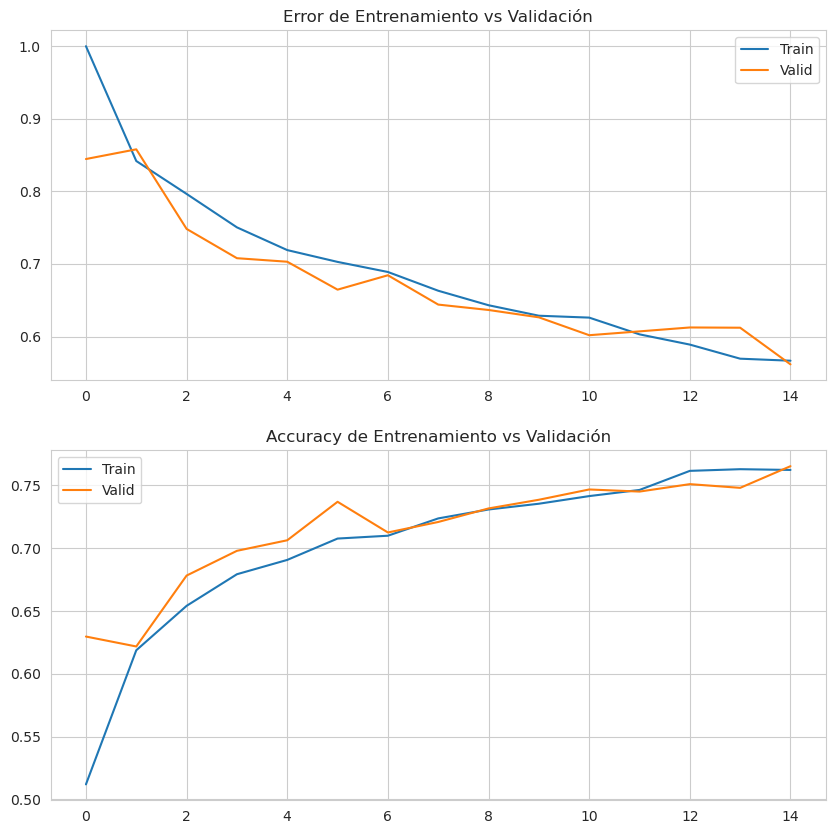

In [111]:
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

axs[0].plot(history["train_loss"])
axs[0].plot(history["valid_loss"])
axs[0].title.set_text('Error de Entrenamiento vs Validación')
axs[0].legend(['Train', 'Valid'])

axs[1].plot(history["train_acc"])
axs[1].plot(history["valid_acc"])
axs[1].title.set_text('Accuracy de Entrenamiento vs Validación')
axs[1].legend(['Train', 'Valid'])

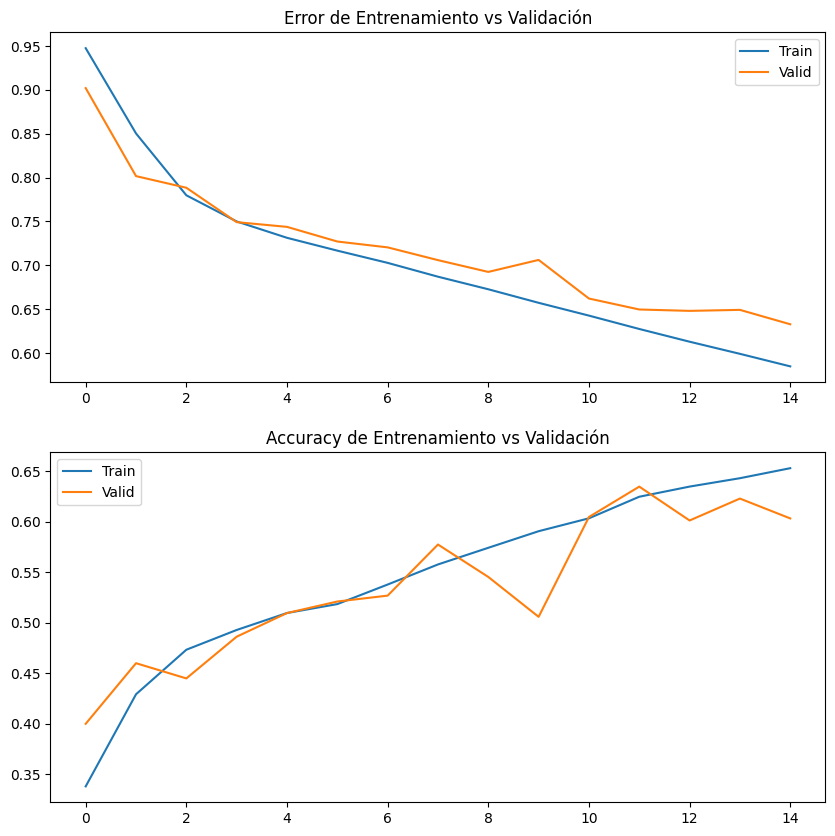

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

axs[0].plot(history["train_loss"])
axs[0].plot(history["valid_loss"])
axs[0].title.set_text('Error de Entrenamiento vs Validación')
axs[0].legend(['Train', 'Valid'])

axs[1].plot(history["train_acc"])
axs[1].plot(history["valid_acc"])
axs[1].title.set_text('Accuracy de Entrenamiento vs Validación')
axs[1].legend(['Train', 'Valid'])

2. DATA AUGMENTATION

Como estamos trabajando con imágenes de caras de personas, es importante asegurarnos de que las transformaciones no distorsionen los rasgos faciales. Por ejemplo, hacer una rotación demasiado grande o un escalado excesivo podría alterar la posición de los ojos, la nariz o la boca, lo cual podría hacer que el modelo no aprenda correctamente.

Transformaciones propuestas:

- transforms.RandomHorizontalFlip:

Refleja las caras horizontalmente sin perder ningún detalle relevante. Esto puede ayudar al modelo a aprender a reconocer las caras sin importar la dirección en la que están orientadas.
Uso: transforms.RandomHorizontalFlip(p=0.5) (50% de probabilidad de hacer el flip).

- transforms.RandomRotation:

Las rotaciones moderadas pensamos que pueden ser útiles en este caso.
Uso: transforms.RandomRotation(degrees=15) (esto permite rotaciones aleatorias de hasta 15 grados en ambas direcciones).

- transforms.ColorJitter:

Esta transformación ajusta aleatoriamente el brillo, contraste, saturación y tonalidad de la imagen. Ayuda a hacer que el modelo sea robusto frente a variaciones de iluminación y color en las caras.
Uso: transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1).


- transforms.RandomAffine:

Permite aplicar transformaciones de traslación, rotación, escalado y/o sesgo en las imágenes.
Uso: transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.8, 1.2)). Esto permite pequeñas rotaciones (10°), desplazamientos (10% de la imagen) y escalados moderados.

- transforms.RandomPerspective:

Realiza transformaciones de perspectiva que pueden hacer que la imagen se vea como si fuera tomada desde otro ángulo. Es útil para robustecer al modelo frente a cambios de perspectiva de la imagen.
Uso: transforms.RandomPerspective(distortion_scale=0.5, p=0.5, interpolation=3).

In [ ]:
# Dataset simulado
class AugmentedDataset(Dataset):
    def __init__(self, images, labels, transform=None, augment_multiplier=3):
        """
        Dataset aumentado dinámicamente.
        :param images: Lista de imágenes originales.
        :param labels: Etiquetas correspondientes.
        :param transform: Transformaciones a aplicar.
        :param augment_multiplier: Número de veces que se verá cada imagen aumentada.
        """
        self.images = images
        self.labels = labels
        self.transform = transform
        self.augment_multiplier = augment_multiplier

    def __len__(self):
        return len(self.images) * self.augment_multiplier




    def __getitem__(self, idx):
        # Generar un índice circular para repetir imágenes
        img_idx = idx % len(self.images)

        img_name = self.dataframe.iloc[idx, 0]  # Nombre de la imagen (ID)
        label = self.dataframe.iloc[idx, 1]     # Clase correspondiente
        img_path = os.path.join(self.images_dir, img_name)

        image = Image.open(img_path).convert('RGB')


        # Aplicar transformaciones
        if self.transform:
            image = self.transform(image)

        return image, label

In [120]:
aug_data_transforms = torchvision.transforms.Compose([
                        torchvision.transforms.Resize((ANCHO_IMAGENES, ALTO_IMAGENES), interpolation=Image.LANCZOS),
                        torchvision.transforms.RandomHorizontalFlip(0.5),
                        # torchvision.transforms.RandomRotation(degrees=5),
                        torchvision.transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
                        #torchvision.transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.8, 1.2)),
                        #torchvision.transforms.RandomPerspective(distortion_scale=0.5, p=0.5, interpolation=3),
                        torchvision.transforms.ToTensor(),
                      ])


In [121]:
transforms = torchvision.transforms.Compose([
                    torchvision.transforms.Resize((ANCHO_IMAGENES, ALTO_IMAGENES), interpolation=Image.LANCZOS),
                    torchvision.transforms.ToTensor()
                  ])

images_dir = path+'/faces/Train'

# Creamos los Datasets
aug_train_set = CustomDataset(dataframe=train_df, images_dir=images_dir, transform=aug_data_transforms)
aug_test_set = CustomDataset(dataframe=test_df, images_dir=images_dir, transform=transforms)

# Creamos los DataLoaders
aug_train_loader = DataLoader(aug_train_set, batch_size=64, shuffle=True)
aug_test_loader = DataLoader(aug_test_set, batch_size=64, shuffle=False)


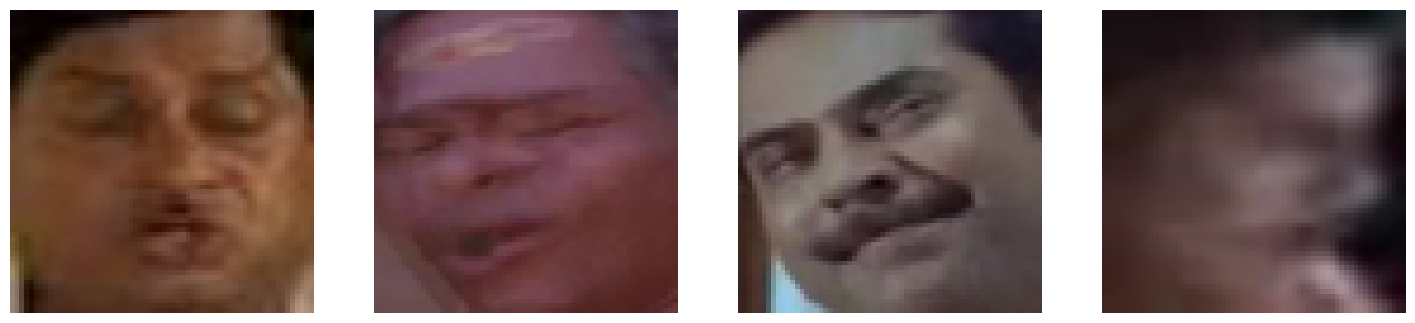

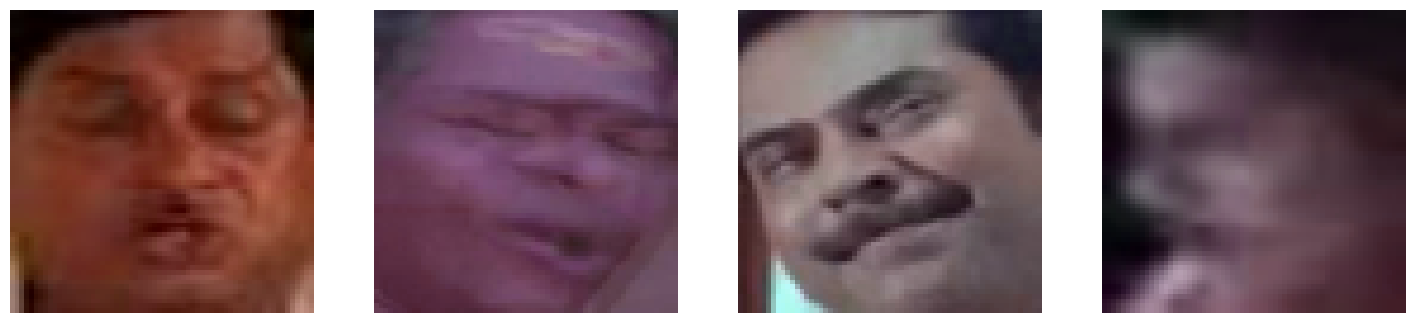

In [122]:
images_ids = np.random.randint(low=0, high=len(train_dataset), size=4)

# Ploteo las imagenes sin augmentacion

fig, rows = plt.subplots(nrows=1, ncols=4, figsize=(18, 18))

for id, row in enumerate(rows):
    row.imshow(train_dataset[images_ids[id]][0].permute(1, 2, 0))
    row.axis('off')
plt.show()

# Ploteo las mismas imagenes con augmentacion

fig, rows = plt.subplots(nrows=1, ncols=4, figsize=(18, 18))

for id, row in enumerate(rows):
    row.imshow(aug_train_set[images_ids[id]][0].permute(1, 2, 0))
    row.axis('off')
plt.show()

Epoch: 1/15 - Train loss 1.044198 - Train Accuracy 0.463390 - Valid Loss 0.953484 - Valid Accuracy 0.558353
Epoch: 2/15 - Train loss 0.917259 - Train Accuracy 0.570707 - Valid Loss 0.866521 - Valid Accuracy 0.613162
Epoch: 3/15 - Train loss 0.859978 - Train Accuracy 0.614979 - Valid Loss 0.785697 - Valid Accuracy 0.648365
Epoch: 4/15 - Train loss 0.829048 - Train Accuracy 0.630527 - Valid Loss 0.766893 - Valid Accuracy 0.683091
Epoch: 5/15 - Train loss 0.784301 - Train Accuracy 0.656356 - Valid Loss 0.742752 - Valid Accuracy 0.693983
Epoch: 6/15 - Train loss 0.776142 - Train Accuracy 0.663553 - Valid Loss 0.711039 - Valid Accuracy 0.707657
Epoch: 7/15 - Train loss 0.757683 - Train Accuracy 0.676178 - Valid Loss 0.694329 - Valid Accuracy 0.701240
Epoch: 8/15 - Train loss 0.744537 - Train Accuracy 0.681934 - Valid Loss 0.684398 - Valid Accuracy 0.710630
Epoch: 9/15 - Train loss 0.731359 - Train Accuracy 0.686931 - Valid Loss 0.705367 - Valid Accuracy 0.703931
Epoch: 10/15 - Train loss 0.

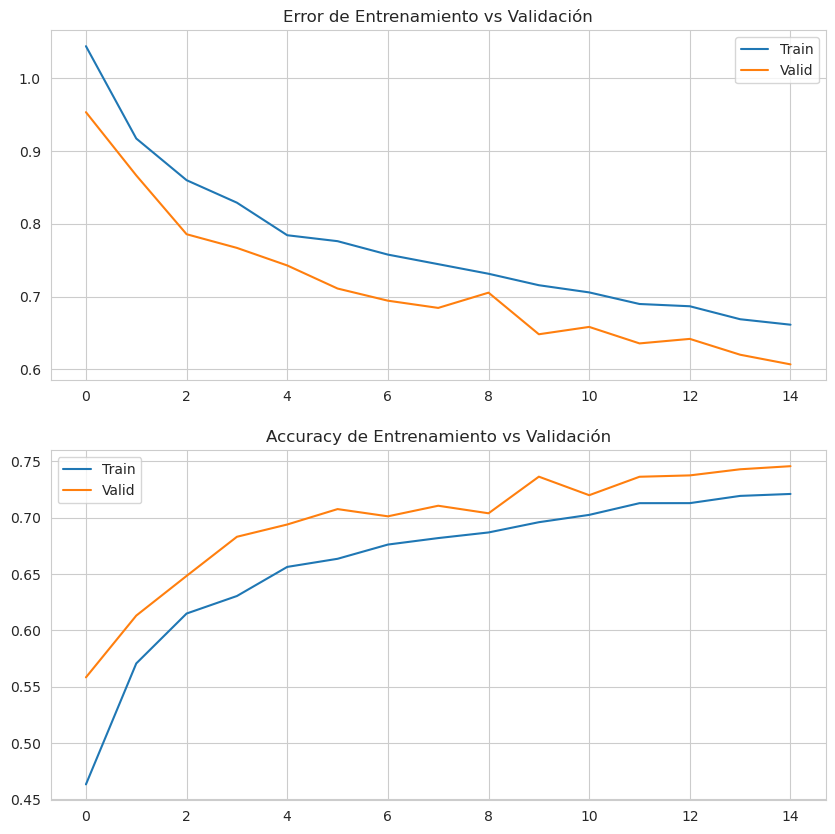

In [119]:
aug_conv_model = ConvModel(CANTIDAD_CLASES)
aug_optimizer = torch.optim.Adam(aug_conv_model.parameters(), lr=0.001, weight_decay=0.001)
aug_loss = torch.nn.CrossEntropyLoss(weight=weights)
aug_metric = torchmetrics.Accuracy(task='multiclass', num_classes=CANTIDAD_CLASES,average='macro')
aug_data = {"train": aug_train_loader, "valid": aug_test_loader, "image_width": ANCHO_IMAGENES, "image_height": ALTO_IMAGENES}

aug_writer = {"train": SummaryWriter(log_dir="data_aug/aug_train"),
              "valid": SummaryWriter(log_dir="data_aug/aug_valid")}

history = train(aug_conv_model,
                aug_optimizer,
                aug_loss,
                aug_metric,
                aug_data,
                15,
                aug_writer)

fig, axs = plt.subplots(2, 1, figsize=(10, 10))

axs[0].plot(history["train_loss"])
axs[0].plot(history["valid_loss"])
axs[0].title.set_text('Error de Entrenamiento vs Validación')
axs[0].legend(['Train', 'Valid'])

axs[1].plot(history["train_acc"])
axs[1].plot(history["valid_acc"])
axs[1].title.set_text('Accuracy de Entrenamiento vs Validación')
axs[1].legend(['Train', 'Valid'])

# arquitectura basica
# Epoch: 15/15 - Train loss 0.584816 - Train Accuracy 0.653090 - Valid Loss 0.632798 - Valid Accuracy 0.603356
# Epoch: 15/15 - Train loss 0.511090 - Train Accuracy 0.788889 - Valid Loss 0.575703 - Valid Accuracy 0.768427

El proceso de data augmentation mejoró sustancialmente las métricas de performance

3. TRANSFER LEARNING: VGG19


In [ ]:
CANTIDAD_CLASES = 3
ANCHO_IMAGENES = 150
ALTO_IMAGENES = 150

In [126]:
from torchvision.models.vgg import VGG19_Weights

weights = VGG19_Weights.IMAGENET1K_V1
transforms = weights.transforms()

In [127]:
vgg19_model = torchvision.models.vgg19( weights=weights)

#vgg19_model.to("cuda")
#torchsummary.summary(vgg19_model, input_size=(3, 224, 224))
#vgg19_model.modules

In [128]:
aug_data_transforms = torchvision.transforms.Compose([
                        #torchvision.transforms.Resize((ANCHO_IMAGENES, ALTO_IMAGENES), interpolation=Image.LANCZOS),
                        torchvision.transforms.RandomHorizontalFlip(0.5),
                        torchvision.transforms.RandomRotation(degrees=25),
                        torchvision.transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
                        #torchvision.transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.8, 1.2)),
                        #torchvision.transforms.RandomPerspective(distortion_scale=0.5, p=0.5, interpolation=3),
                        torchvision.transforms.ToTensor(),
                      ])

transforms = torchvision.transforms.Compose([
                    #torchvision.transforms.Resize((ANCHO_IMAGENES, ALTO_IMAGENES), interpolation=Image.LANCZOS),
                    torchvision.transforms.ToTensor()
                  ])


images_dir = '/content/faces-age-detection-dataset/faces/Train'

# Creamos los Datasets
aug_train_set = CustomDataset(dataframe=train_df, images_dir=images_dir, transform=aug_data_transforms)
aug_test_set = CustomDataset(dataframe=test_df, images_dir=images_dir, transform=transforms)

# Creamos los DataLoaders
aug_train_loader = DataLoader(aug_train_set, batch_size=64, shuffle=True)
aug_test_loader = DataLoader(aug_test_set, batch_size=64, shuffle=False)


In [129]:
for param in vgg19_model.parameters():
    param.requires_grad = False

In [130]:
last_layer_in_features = vgg19_model.classifier[-1].in_features
vgg19_model.classifier[-1] = torch.nn.Linear(in_features=last_layer_in_features, out_features=CANTIDAD_CLASES)


In [131]:
def train(model, optimizer, criterion, metric, data, epochs, tb_writer=None):

    train_loader = data["train"]
    valid_loader = data["valid"]

    train_writer = tb_writer["train"]
    valid_writer = tb_writer["valid"]


    if tb_writer:

        train_writer.add_graph(model, torch.zeros((1, 3), data["image_width"], data["image_height"]))
        valid_writer.add_graph(model, torch.zeros((1, 3), data["image_width"], data["image_height"]))

    if torch.cuda.is_available():
        model.to("cuda")
        metric.to("cuda")

    train_loss = []
    train_acc = []
    valid_loss = []
    valid_acc = []

    for epoch in range(epochs):

        # Pongo el modelo en modo entrenamiento
        model.train()

        epoch_train_loss = 0.0
        epoch_train_accuracy = 0.0

        for train_data, train_target in train_loader:

            if torch.cuda.is_available():
                train_data = train_data.to("cuda")
                train_target = train_target.to("cuda")

            optimizer.zero_grad()
            output = model(train_data.float())
            loss = criterion(output, train_target)
            epoch_train_loss += loss.item()
            loss.backward()
            optimizer.step()

            accuracy = metric(output, train_target)
            epoch_train_accuracy += accuracy.item()

        epoch_train_loss = epoch_train_loss / len(train_loader)
        epoch_train_accuracy = epoch_train_accuracy / len(train_loader)
        train_loss.append(epoch_train_loss)
        train_acc.append(epoch_train_accuracy)

        # Pongo el modelo en modo testeo
        model.eval()

        epoch_valid_loss = 0.0
        epoch_valid_accuracy = 0.0

        for valid_data, valid_target in valid_loader:
            if torch.cuda.is_available():
                valid_data = valid_data.to("cuda")
                valid_target = valid_target.to("cuda")

            output = model(valid_data.float())
            epoch_valid_loss += criterion(output, valid_target).item()
            epoch_valid_accuracy += metric(output, valid_target).item()

        epoch_valid_loss = epoch_valid_loss / len(valid_loader)
        epoch_valid_accuracy = epoch_valid_accuracy / len(valid_loader)
        valid_loss.append(epoch_valid_loss)
        valid_acc.append(epoch_valid_accuracy)

        print("Epoch: {}/{} - Train loss {:.6f} - Train Accuracy {:.6f} - Valid Loss {:.6f} - Valid Accuracy {:.6f}".format(
        epoch+1, epochs, epoch_train_loss, epoch_train_accuracy, epoch_valid_loss, epoch_valid_accuracy))

        if tb_writer:
            train_writer.add_scalar("loss", epoch_train_loss, epoch)
            valid_writer.add_scalar("loss", epoch_valid_loss, epoch)
            train_writer.add_scalar("accuracy", epoch_train_accuracy, epoch)
            valid_writer.add_scalar("accuracy", epoch_valid_accuracy, epoch)
            train_writer.flush()
            valid_writer.flush()

    history = {}
    history["train_loss"] = train_loss
    history["train_acc"] = train_acc
    history["valid_loss"] = valid_loss
    history["valid_acc"] = valid_acc

    return history

In [132]:
optimizer = torch.optim.Adam(vgg19_model.parameters(), lr=0.0001)
loss = torch.nn.CrossEntropyLoss()
metric = torchmetrics.Accuracy(task='multiclass', num_classes=CANTIDAD_CLASES,average='macro' )
data = {"train": aug_train_loader, "valid": aug_test_loader, "image_width": ANCHO_IMAGENES, "image_height": ALTO_IMAGENES}
writer = {"train": SummaryWriter(log_dir="transfer_learning_vgg/train"),
          "valid": SummaryWriter(log_dir="transfer_learning_vgg/valid")}


history = train(vgg19_model,#.to('cpu'),
                optimizer,
                loss,
                metric,
                data,
                15,
                writer)

fig, axs = plt.subplots(2, 1, figsize=(10, 10))

axs[0].plot(history["train_loss"])
axs[0].plot(history["valid_loss"])
axs[0].title.set_text('Error de Entrenamiento vs Test')
axs[0].legend(['Train', 'Test'])

axs[1].plot(history["train_acc"])
axs[1].plot(history["valid_acc"])
axs[1].title.set_text('Accuracy de Entrenamiento vs Test')
axs[1].legend(['Train', 'Test'])

# arquitectura basica
# Epoch: 15/15 - Train loss 0.584816 - Train Accuracy 0.653090 - Valid Loss 0.632798 - Valid Accuracy 0.603356
# data augmentation
# Epoch: 15/15 - Train loss 0.530651 - Train Accuracy 0.700656 - Valid Loss 0.544694 - Valid Accuracy 0.701688

TypeError: zeros() received an invalid combination of arguments - got (tuple, int, int), but expected one of:
 * (tuple of ints size, *, tuple of names names, torch.dtype dtype, torch.layout layout, torch.device device, bool pin_memory, bool requires_grad)
 * (tuple of ints size, *, Tensor out, torch.dtype dtype, torch.layout layout, torch.device device, bool pin_memory, bool requires_grad)


4. TRANSFER LEARNING: RESNET18

In [ ]:
from torchvision.models import resnet18, ResNet18_Weights

weights = ResNet18_Weights.IMAGENET1K_V1
transforms = weights.transforms()

In [ ]:
resnet18_model = resnet18(weights=weights)

if torch.cuda.is_available():
    resnet18_model.to("cuda")

torchsummary.summary(resnet18_model, input_size=(3, 32, 32))
resnet18_model.modules

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:06<00:00, 7.76MB/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          36,864
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
       BasicBlock-11             [-1, 64, 8, 8]               0
           Conv2d-12             [-1, 64, 8, 8]          36,864
      BatchNorm2d-13             [-1, 64, 8, 8]             128
             ReLU-14             [-1, 6

<bound method Module.modules of ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (layer2): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (downsample): Sequential(
        (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): BasicBlock(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (layer3): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (downsample): Sequential(
        (0): Conv2d(128, 256, kernel_size=(1, 1), stride=(2, 2), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): BasicBlock(
      (conv1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (layer4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (downsample): Sequential(
        (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(

In [ ]:
for param in resnet18_model.parameters():
    param.requires_grad = False

last_layer_in_features = resnet18_model.fc.in_features
resnet18_model.fc = torch.nn.Linear(in_features=last_layer_in_features, out_features=CANTIDAD_CLASES)

NameError: name 'CANTIDAD_CLASES' is not defined

In [ ]:
aug_data_transforms = torchvision.transforms.Compose([
                        torchvision.transforms.Resize((ANCHO_IMAGENES, ALTO_IMAGENES), interpolation=Image.LANCZOS),
                        torchvision.transforms.RandomHorizontalFlip(0.5),
                        torchvision.transforms.RandomRotation(degrees=25),
                        torchvision.transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
                        #torchvision.transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.8, 1.2)),
                        #torchvision.transforms.RandomPerspective(distortion_scale=0.5, p=0.5, interpolation=3),
                        torchvision.transforms.ToTensor(),
                      ])

transforms = torchvision.transforms.Compose([
                    torchvision.transforms.Resize((ANCHO_IMAGENES, ALTO_IMAGENES), interpolation=Image.LANCZOS),
                    torchvision.transforms.ToTensor()
                  ])



images_dir = '/content/faces-age-detection-dataset/faces/Train'  # Cambia esto a la ruta de tu carpeta de imágenes

# Crear Datasets
aug_train_set = CustomDataset(dataframe=train_df, images_dir=images_dir, transform=aug_data_transforms)
aug_test_set = CustomDataset(dataframe=test_df, images_dir=images_dir, transform=transforms)

# Crear DataLoaders
aug_train_loader = DataLoader(aug_train_set, batch_size=64, shuffle=True)
aug_test_loader = DataLoader(aug_test_set, batch_size=64, shuffle=False)

Epoch: 1/15 - Train loss 0.985177 - Train Accuracy 0.374684 - Valid Loss 0.968115 - Valid Accuracy 0.385228
Epoch: 2/15 - Train loss 0.895310 - Train Accuracy 0.419243 - Valid Loss 0.934302 - Valid Accuracy 0.418434
Epoch: 3/15 - Train loss 0.866865 - Train Accuracy 0.437861 - Valid Loss 0.923185 - Valid Accuracy 0.431637
Epoch: 4/15 - Train loss 0.847533 - Train Accuracy 0.449203 - Valid Loss 0.918754 - Valid Accuracy 0.446518
Epoch: 5/15 - Train loss 0.835963 - Train Accuracy 0.457448 - Valid Loss 0.897940 - Valid Accuracy 0.445474
Epoch: 6/15 - Train loss 0.820139 - Train Accuracy 0.467866 - Valid Loss 0.892738 - Valid Accuracy 0.451844
Epoch: 7/15 - Train loss 0.813855 - Train Accuracy 0.469385 - Valid Loss 0.900516 - Valid Accuracy 0.451099
Epoch: 8/15 - Train loss 0.805010 - Train Accuracy 0.481770 - Valid Loss 0.887045 - Valid Accuracy 0.451594
Epoch: 9/15 - Train loss 0.802300 - Train Accuracy 0.482244 - Valid Loss 0.878832 - Valid Accuracy 0.461448
Epoch: 10/15 - Train loss 0.

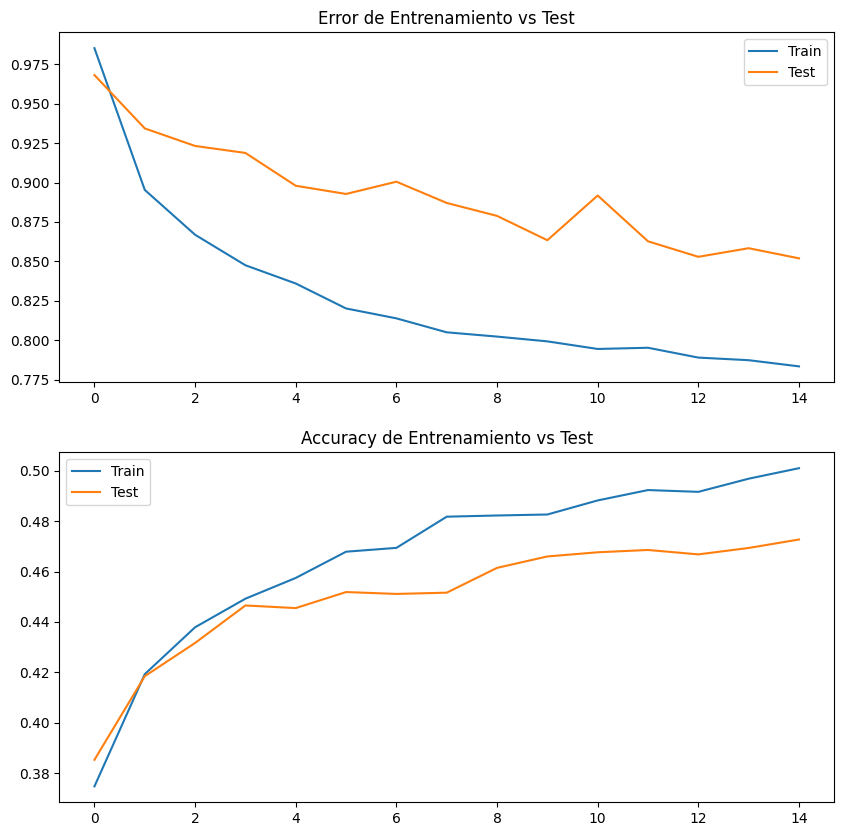

In [ ]:
optimizer = torch.optim.Adam(resnet18_model.parameters(), lr=0.0001)
loss = torch.nn.CrossEntropyLoss()
metric = torchmetrics.Accuracy(task='multiclass', num_classes=CANTIDAD_CLASES,average='macro' )
data = {"train": aug_train_loader, "valid": aug_test_loader, "image_width": ANCHO_IMAGENES, "image_height": ALTO_IMAGENES}
writer = {"train": SummaryWriter(log_dir="transfer_learning_resnet18/train"),
          "valid": SummaryWriter(log_dir="transfer_learning_resnet18/valid")}


history = train(resnet18_model.to('cpu'),
                optimizer,
                loss,
                metric,
                data,
                15,
                writer)

fig, axs = plt.subplots(2, 1, figsize=(10, 10))

axs[0].plot(history["train_loss"])
axs[0].plot(history["valid_loss"])
axs[0].title.set_text('Error de Entrenamiento vs Test')
axs[0].legend(['Train', 'Test'])

axs[1].plot(history["train_acc"])
axs[1].plot(history["valid_acc"])
axs[1].title.set_text('Accuracy de Entrenamiento vs Test')
axs[1].legend(['Train', 'Test'])

# arquitectura basica
# Epoch: 15/15 - Train loss 0.584816 - Train Accuracy 0.653090 - Valid Loss 0.632798 - Valid Accuracy 0.603356
# data augmentation
# Epoch: 15/15 - Train loss 0.530651 - Train Accuracy 0.700656 - Valid Loss 0.544694 - Valid Accuracy 0.701688
# TL vgg19
# Epoch: 15/15 - Train loss 0.817499 - Train Accuracy 0.479971 - Valid Loss 0.834366 - Valid Accuracy 0.478292

5. TL RESNET18 DESDE LAYER4

In [ ]:
CANTIDAD_CLASES = 3
ANCHO_IMAGENES = 150
ALTO_IMAGENES = 150

In [ ]:
from torchvision.models import resnet18, ResNet18_Weights

weights = ResNet18_Weights.IMAGENET1K_V1
transforms = weights.transforms()

In [ ]:
resnet18_model = resnet18(weights=weights)

if torch.cuda.is_available():
    resnet18_model.to("cuda")

torchsummary.summary(resnet18_model, input_size=(3, 32, 32))
resnet18_model.modules

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          36,864
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
       BasicBlock-11             [-1, 64, 8, 8]               0
           Conv2d-12             [-1, 64, 8, 8]          36,864
      BatchNorm2d-13             [-1, 64, 8, 8]             128
             ReLU-14             [-1, 6

<bound method Module.modules of ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (layer2): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (downsample): Sequential(
        (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): BasicBlock(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (layer3): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (downsample): Sequential(
        (0): Conv2d(128, 256, kernel_size=(1, 1), stride=(2, 2), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): BasicBlock(
      (conv1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (layer4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (downsample): Sequential(
        (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(

In [ ]:
for param in resnet18_model.parameters():
    param.requires_grad = False


def check_requires_grad(model):
    for name, param in model.named_parameters():
        print(f'{name}: requires_grad = {param.requires_grad}')

# Llama a la función con tu modelo
check_requires_grad(resnet18_model)



conv1.weight: requires_grad = False
bn1.weight: requires_grad = False
bn1.bias: requires_grad = False
layer1.0.conv1.weight: requires_grad = False
layer1.0.bn1.weight: requires_grad = False
layer1.0.bn1.bias: requires_grad = False
layer1.0.conv2.weight: requires_grad = False
layer1.0.bn2.weight: requires_grad = False
layer1.0.bn2.bias: requires_grad = False
layer1.1.conv1.weight: requires_grad = False
layer1.1.bn1.weight: requires_grad = False
layer1.1.bn1.bias: requires_grad = False
layer1.1.conv2.weight: requires_grad = False
layer1.1.bn2.weight: requires_grad = False
layer1.1.bn2.bias: requires_grad = False
layer2.0.conv1.weight: requires_grad = False
layer2.0.bn1.weight: requires_grad = False
layer2.0.bn1.bias: requires_grad = False
layer2.0.conv2.weight: requires_grad = False
layer2.0.bn2.weight: requires_grad = False
layer2.0.bn2.bias: requires_grad = False
layer2.0.downsample.0.weight: requires_grad = False
layer2.0.downsample.1.weight: requires_grad = False
layer2.0.downsample.

In [ ]:
for layer in resnet18_model.layer4:  # Iterar sobre todas las capas del último bloque
    for param in layer.parameters():
        param.requires_grad = True  # Habilitar todas las capas dentro de layer4

# No olvidar permitir que la capa de clasificación también se entrene
last_layer_in_features = resnet18_model.fc.in_features
resnet18_model.fc = torch.nn.Linear(in_features=last_layer_in_features, out_features=CANTIDAD_CLASES)

# Llama a la función con tu modelo
check_requires_grad(resnet18_model)

conv1.weight: requires_grad = False
bn1.weight: requires_grad = False
bn1.bias: requires_grad = False
layer1.0.conv1.weight: requires_grad = False
layer1.0.bn1.weight: requires_grad = False
layer1.0.bn1.bias: requires_grad = False
layer1.0.conv2.weight: requires_grad = False
layer1.0.bn2.weight: requires_grad = False
layer1.0.bn2.bias: requires_grad = False
layer1.1.conv1.weight: requires_grad = False
layer1.1.bn1.weight: requires_grad = False
layer1.1.bn1.bias: requires_grad = False
layer1.1.conv2.weight: requires_grad = False
layer1.1.bn2.weight: requires_grad = False
layer1.1.bn2.bias: requires_grad = False
layer2.0.conv1.weight: requires_grad = False
layer2.0.bn1.weight: requires_grad = False
layer2.0.bn1.bias: requires_grad = False
layer2.0.conv2.weight: requires_grad = False
layer2.0.bn2.weight: requires_grad = False
layer2.0.bn2.bias: requires_grad = False
layer2.0.downsample.0.weight: requires_grad = False
layer2.0.downsample.1.weight: requires_grad = False
layer2.0.downsample.

In [ ]:
aug_data_transforms = torchvision.transforms.Compose([
                        torchvision.transforms.Resize((ANCHO_IMAGENES, ALTO_IMAGENES), interpolation=Image.LANCZOS),
                        torchvision.transforms.RandomHorizontalFlip(0.5),
                        torchvision.transforms.RandomRotation(degrees=25),
                        torchvision.transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
                        #torchvision.transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.8, 1.2)),
                        #torchvision.transforms.RandomPerspective(distortion_scale=0.5, p=0.5, interpolation=3),
                        torchvision.transforms.ToTensor(),
                      ])

transforms = torchvision.transforms.Compose([
                    torchvision.transforms.Resize((ANCHO_IMAGENES, ALTO_IMAGENES), interpolation=Image.LANCZOS),
                    torchvision.transforms.ToTensor()
                  ])



images_dir = '/content/faces-age-detection-dataset/faces/Train'  # Cambia esto a la ruta de tu carpeta de imágenes

# Crear Datasets
aug_train_set = CustomDataset(dataframe=train_df, images_dir=images_dir, transform=aug_data_transforms)
aug_test_set = CustomDataset(dataframe=test_df, images_dir=images_dir, transform=transforms)

# Crear DataLoaders
aug_train_loader = DataLoader(aug_train_set, batch_size=64, shuffle=True)
aug_test_loader = DataLoader(aug_test_set, batch_size=64, shuffle=False)

Epoch: 1/15 - Train loss 0.715007 - Train Accuracy 0.572244 - Valid Loss 0.658022 - Valid Accuracy 0.629074
Epoch: 2/15 - Train loss 0.574380 - Train Accuracy 0.673287 - Valid Loss 0.609721 - Valid Accuracy 0.662581
Epoch: 3/15 - Train loss 0.512554 - Train Accuracy 0.726234 - Valid Loss 0.560053 - Valid Accuracy 0.691981
Epoch: 4/15 - Train loss 0.460065 - Train Accuracy 0.759085 - Valid Loss 0.541177 - Valid Accuracy 0.738905
Epoch: 5/15 - Train loss 0.417716 - Train Accuracy 0.783661 - Valid Loss 0.525868 - Valid Accuracy 0.715566
Epoch: 6/15 - Train loss 0.387226 - Train Accuracy 0.807240 - Valid Loss 0.496810 - Valid Accuracy 0.776661
Epoch: 7/15 - Train loss 0.354395 - Train Accuracy 0.830953 - Valid Loss 0.498243 - Valid Accuracy 0.760762
Epoch: 8/15 - Train loss 0.323002 - Train Accuracy 0.842174 - Valid Loss 0.474271 - Valid Accuracy 0.752820
Epoch: 9/15 - Train loss 0.307550 - Train Accuracy 0.851312 - Valid Loss 0.462304 - Valid Accuracy 0.804507
Epoch: 10/15 - Train loss 0.

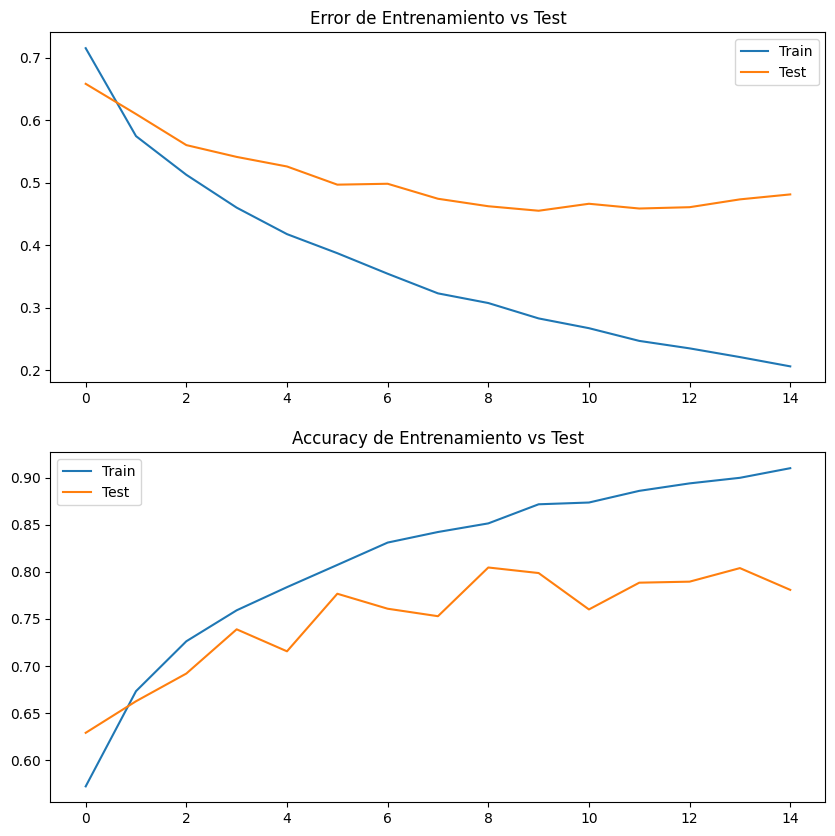

In [ ]:
optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, resnet18_model.parameters()),
    lr=0.0001)

#optimizer = torch.optim.Adam(resnet18_model.parameters(), lr=0.0001)
loss = torch.nn.CrossEntropyLoss()
metric = torchmetrics.Accuracy(task='multiclass', num_classes=CANTIDAD_CLASES,average='macro' )
data = {"train": aug_train_loader, "valid": aug_test_loader, "image_width": ANCHO_IMAGENES, "image_height": ALTO_IMAGENES}
writer = {"train": SummaryWriter(log_dir="transfer_learning_resnet18/train"),
          "valid": SummaryWriter(log_dir="transfer_learning_resnet18/valid")}


history = train(resnet18_model.to('cpu'),
                optimizer,
                loss,
                metric,
                data,
                15,
                writer)

fig, axs = plt.subplots(2, 1, figsize=(10, 10))

axs[0].plot(history["train_loss"])
axs[0].plot(history["valid_loss"])
axs[0].title.set_text('Error de Entrenamiento vs Test')
axs[0].legend(['Train', 'Test'])

axs[1].plot(history["train_acc"])
axs[1].plot(history["valid_acc"])
axs[1].title.set_text('Accuracy de Entrenamiento vs Test')
axs[1].legend(['Train', 'Test'])

# arquitectura basica
# Epoch: 15/15 - Train loss 0.584816 - Train Accuracy 0.653090 - Valid Loss 0.632798 - Valid Accuracy 0.603356
# data augmentation
# Epoch: 15/15 - Train loss 0.530651 - Train Accuracy 0.700656 - Valid Loss 0.544694 - Valid Accuracy 0.701688
# TL vgg19 fc
# Epoch: 15/15 - Train loss 0.817499 - Train Accuracy 0.479971 - Valid Loss 0.834366 - Valid Accuracy 0.478292
# TL resnet18 fc
# Epoch: 15/15 - Train loss 0.783415 - Train Accuracy 0.501027 - Valid Loss 0.851920 - Valid Accuracy 0.472704


In [ ]:
train_df.Class.value_counts(dropna=False).sort_index()

,count
Class,
0,5364
1,8643
2,1917


In [ ]:
frecuencias = train_df.Class.value_counts(dropna=False).sort_index().to_list()
frecuencias

[5364, 8643, 1917]

In [ ]:
weights = [1.0 / f for f in frecuencias]

print(weights)

normalized_weights = [w / sum(weights) for w in weights]
print(normalized_weights)

[0.00018642803877703205, 0.00011570056693277797, 0.0005216484089723526]
[0.22630886205165784, 0.14045131737187233, 0.6332398205764698]


In [ ]:
class_weights_tensor = torch.FloatTensor(normalized_weights)

In [ ]:
class_weights_tensor = class_weights_tensor.to('cuda')

Epoch: 1/15 - Train loss 0.807325 - Train Accuracy 0.640558 - Valid Loss 0.688195 - Valid Accuracy 0.704967
Epoch: 2/15 - Train loss 0.629604 - Train Accuracy 0.736084 - Valid Loss 0.644769 - Valid Accuracy 0.723806
Epoch: 3/15 - Train loss 0.562901 - Train Accuracy 0.767959 - Valid Loss 0.622664 - Valid Accuracy 0.742087
Epoch: 4/15 - Train loss 0.501482 - Train Accuracy 0.800193 - Valid Loss 0.600855 - Valid Accuracy 0.744160
Epoch: 5/15 - Train loss 0.464692 - Train Accuracy 0.810831 - Valid Loss 0.631474 - Valid Accuracy 0.748692
Epoch: 6/15 - Train loss 0.413342 - Train Accuracy 0.840556 - Valid Loss 0.559446 - Valid Accuracy 0.777130
Epoch: 7/15 - Train loss 0.387138 - Train Accuracy 0.849492 - Valid Loss 0.540578 - Valid Accuracy 0.789387
Epoch: 8/15 - Train loss 0.371341 - Train Accuracy 0.857490 - Valid Loss 0.608292 - Valid Accuracy 0.780726
Epoch: 9/15 - Train loss 0.333617 - Train Accuracy 0.872162 - Valid Loss 0.531330 - Valid Accuracy 0.799332
Epoch: 10/15 - Train loss 0.

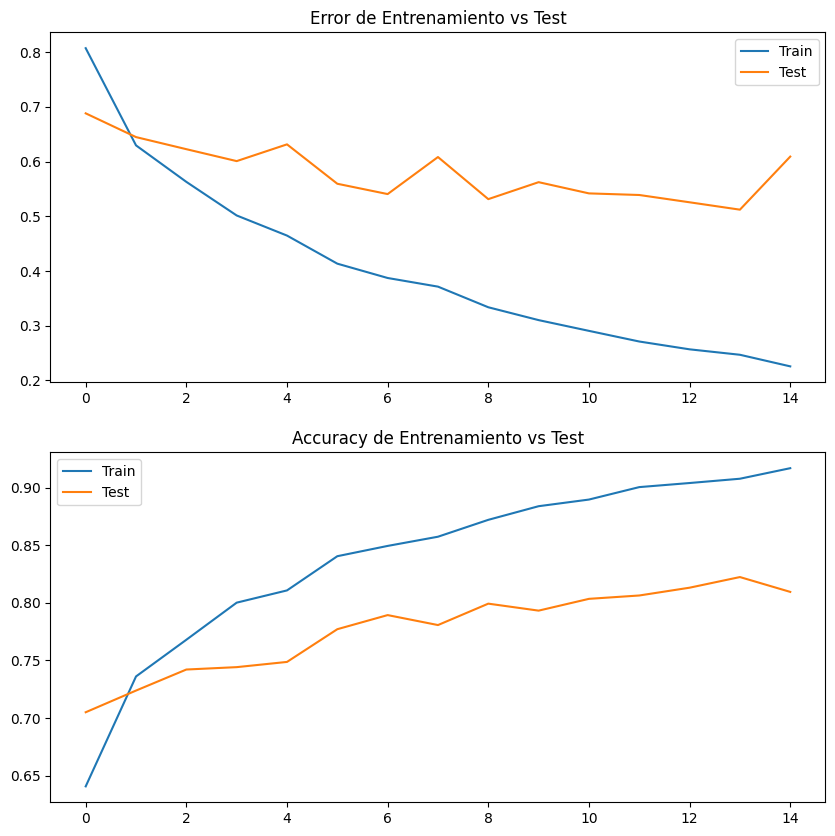

In [ ]:


optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, resnet18_model.parameters()),
    lr=0.0001)

#optimizer = torch.optim.Adam(resnet18_model.parameters(), lr=0.0001)
#loss = torch.nn.CrossEntropyLoss()
loss = torch.nn.CrossEntropyLoss(weight=class_weights_tensor)
metric = torchmetrics.Accuracy(task='multiclass', num_classes=CANTIDAD_CLASES,average='macro' )
data = {"train": aug_train_loader, "valid": aug_test_loader, "image_width": ANCHO_IMAGENES, "image_height": ALTO_IMAGENES}
writer = {"train": SummaryWriter(log_dir="transfer_learning_resnet18/train"),
          "valid": SummaryWriter(log_dir="transfer_learning_resnet18/valid")}


history = train(resnet18_model.to('cpu'),
                optimizer,
                loss,
                metric,
                data,
                15,
                writer)

fig, axs = plt.subplots(2, 1, figsize=(10, 10))

axs[0].plot(history["train_loss"])
axs[0].plot(history["valid_loss"])
axs[0].title.set_text('Error de Entrenamiento vs Test')
axs[0].legend(['Train', 'Test'])

axs[1].plot(history["train_acc"])
axs[1].plot(history["valid_acc"])
axs[1].title.set_text('Accuracy de Entrenamiento vs Test')
axs[1].legend(['Train', 'Test'])

# arquitectura basica
# Epoch: 15/15 - Train loss 0.584816 - Train Accuracy 0.653090 - Valid Loss 0.632798 - Valid Accuracy 0.603356
# data augmentation
# Epoch: 15/15 - Train loss 0.530651 - Train Accuracy 0.700656 - Valid Loss 0.544694 - Valid Accuracy 0.701688
# TL vgg19 fc
# Epoch: 15/15 - Train loss 0.817499 - Train Accuracy 0.479971 - Valid Loss 0.834366 - Valid Accuracy 0.478292
# TL resnet18 fc
# Epoch: 15/15 - Train loss 0.783415 - Train Accuracy 0.501027 - Valid Loss 0.851920 - Valid Accuracy 0.472704
# TL resnet18 layer 4
#Epoch: 15/15 - Train loss 0.206283 - Train Accuracy 0.909893 - Valid Loss 0.481221 - Valid Accuracy 0.780771

In [ ]:
resnet18_model.to('cuda')

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
def calcular_matriz_confusion(model, data_loader):
    model.eval()  # Establecer el modelo en modo evaluación
    y_true = []
    y_pred = []

    with torch.no_grad():  # Desactivar el cálculo de gradientes
        for inputs, labels in data_loader:
            inputs = inputs.to('cuda')  # Mover los inputs a la GPU
            labels = labels.to('cuda')  # Mover las etiquetas a la GPU

            outputs = model(inputs)  # Pasar los inputs por el modelo
            _, predicted = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())  # Mover las etiquetas a la CPU
            y_pred.extend(predicted.cpu().numpy())  # Mover las predicciones a la CPU

    return y_true, y_pred

In [ ]:
import torch
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Asumiendo que calcular_matriz_confusion está definido para obtener y_true y y_pred

# 1. Calcular las etiquetas verdaderas y las predicciones
y_true, y_pred = calcular_matriz_confusion(resnet18_model, aug_test_loader)

# 2. Calcular la matriz de confusión usando sklearn
matriz_confusion = confusion_matrix(y_true, y_pred)

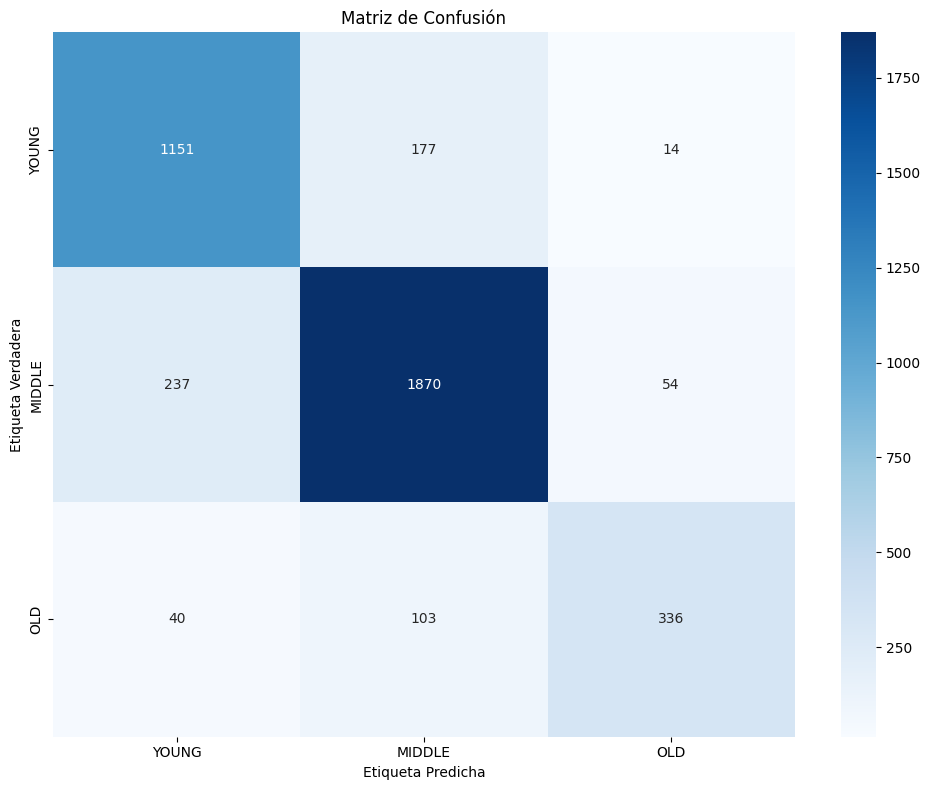

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


def graficar_matriz_confusion(matriz, clases, titulo='Matriz de Confusión', cmap='Blues'):
    plt.figure(figsize=(10, 8))
    sns.heatmap(matriz, annot=True, fmt='d', cmap=cmap,
                xticklabels=clases, yticklabels=clases)

    plt.title(titulo)
    plt.ylabel('Etiqueta Verdadera')
    plt.xlabel('Etiqueta Predicha')
    plt.tight_layout()  # Mejora el espaciado
    plt.show()

# Definir las clases (puedes personalizar estos nombres)
clases = ['YOUNG', 'MIDDLE', 'OLD']  # Sustituye por tus clases

# Graficar la matriz de confusión
graficar_matriz_confusion(matriz_confusion, clases)